deep Q learning agent

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt
import os
import pandas as pd

/opt/conda/lib/python3.8/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
# Define the Q-network
class QNetwork(nn.Module):
    action_dim: int

    def setup(self):
        self.dense1 = nn.Dense(256)
        self.dense2 = nn.Dense(256)
        self.dense3 = nn.Dense(256)
        self.dense4 = nn.Dense(self.action_dim)

    def __call__(self, x):
        x = self.dense1(x)
        x = jax.nn.relu(x)
        x = self.dense2(x)
        x = jax.nn.relu(x)
        x = self.dense3(x)
        x = jax.nn.relu(x)
        x = self.dense4(x)
        return x


In [3]:

# Define the agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, batch_size, buffer_size=100000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)

        self.model = QNetwork(action_dim)
        self.params = self.model.init(jax.random.PRNGKey(42), jnp.zeros((state_dim,)))
        self.optimizer = optax.adam(learning_rate)
        self.opt_state = self.optimizer.init(self.params)
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, apply_epsilon=True, seed=0):
        """
        explore_noise: True for training, False for testing
        """
        if apply_epsilon and np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        q_values = self.model.apply(self.params, state)
        return int(jnp.argmax(q_values))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = list(zip(*batch))
        states = jnp.stack(states)
        actions = jnp.array(actions)
        rewards = jnp.array(rewards)
        next_states = jnp.stack(next_states)
        dones = jnp.array(dones, dtype=jnp.float32)

        def loss_fn(params):
            q_values = self.model.apply(params, states)
            q_next = self.model.apply(params, next_states)
            q_target = rewards + (1.0 - dones) * self.gamma * jnp.max(q_next, axis=1)
            q_pred = jnp.take_along_axis(q_values, actions[:, None], axis=1).squeeze()
            return jnp.mean((q_pred - q_target) ** 2)

        loss, grads = jax.value_and_grad(loss_fn)(self.params)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.params = optax.apply_updates(self.params, updates)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [4]:
# RC model parameters
rc_params = [6.9789902e+03, 2.1591113e+04, 1.8807944e+05, 3.4490612e+00, 4.9556872e-01, 9.8289281e-02, 4.6257420e+00]
x0 = np.array([20, 35.8, 26.])
x_high = np.array([40., 80., 40.])
x_low = np.array([10., 10., 10.])
n_actions = 101
u_high = [0]
u_low = [-10.0] # -12

# load disturbances
file_path = os.path.abspath('')
parent_path = os.path.dirname(file_path)
data_path = os.path.join(parent_path, 'data/disturbance_1min.csv')
data = pd.read_csv(data_path, index_col=[0])
# assign time index
t_base = 181*24*3600 # 7/1
n = len(data)
index = range(t_base, t_base + n*60, 60)
data.index = index

# sample
dt = 900
data = data.groupby([data.index // dt]).mean()
index_dt = range(t_base, t_base + len(data)*dt, dt)
data.index = index_dt 

# get disturbances for lssm
t_d = index_dt
disturbance_names = ['out_temp', 'qint_lump', 'qwin_lump', 'qradin_lump']
disturbance = data[disturbance_names].values


In [5]:
# random seed
seed = 0
np.random.seed(seed)

# Train the agent
import env
ts = 195*24*3600
ndays = 7
te = ndays*24*3600 + ts
weights = [1., 1., 1.] # for energy cost, dT, du
cop = 1.0

env = gym.make("R4C3Discrete-v0",
            rc_params = rc_params,
            x0 = x0,
            x_high = x_high,
            x_low = x_low,
            n_actions = n_actions,
            u_high = u_high,
            u_low = u_low,
            disturbances = (t_d, disturbance),
            cop = cop,
            ts = ts,
            te = te,
            dt = dt,
            weights = weights).env

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01, batch_size=128)

n_episodes = 500
reward_history = []
reward_threshold=175 # env.spec.reward_threshold
solved_window = 50

for episode in range(n_episodes):
    state, _ = env.reset(seed=0)
    print('reset env: ', state[1]) 
    state = jnp.array(state, dtype=jnp.float32)

    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = jnp.array(next_state, dtype=jnp.float32)

        agent.remember(state, action, reward, next_state, done)
        agent.replay()

        state = next_state
        total_reward += reward 

    reward_history.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")

    # stop training if average reward reaches requirement
    # Calculate the average reward over the last 'solved_window' episodes
    if episode >= solved_window:
        avg_reward = np.mean(reward_history[-solved_window:])
        print(f'Episode: {episode}, Average Reward: {avg_reward}')

        if avg_reward >= reward_threshold:
            print(f"RC control solved in {episode} episodes!")
            break

# Plot the historical rewards
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward") 
plt.title("Historical Rewards for RC HVAC")
plt.show()


/opt/conda/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


env is reset!
reset env:  20.136961
Episode 0, Total Reward: -205.46022348067874
env is reset!
reset env:  20.136961
Episode 1, Total Reward: -302.32803997772334
env is reset!
reset env:  20.136961
Episode 2, Total Reward: -98.70820230868875
env is reset!
reset env:  20.136961
Episode 3, Total Reward: -117.11573872301187
env is reset!
reset env:  20.136961
Episode 4, Total Reward: -90.25150009124506
env is reset!
reset env:  20.136961
Episode 5, Total Reward: -106.8559942167658
env is reset!
reset env:  20.136961
Episode 6, Total Reward: -315.1823596355288
env is reset!
reset env:  20.136961
Episode 7, Total Reward: -552.3163083091855
env is reset!
reset env:  20.136961
Episode 8, Total Reward: -394.2423159139735
env is reset!
reset env:  20.136961
Episode 9, Total Reward: -308.0147021626947
env is reset!
reset env:  20.136961
Episode 10, Total Reward: -190.3669172291875
env is reset!
reset env:  20.136961
Episode 11, Total Reward: -206.9876957524363
env is reset!
reset env:  20.136961

KeyboardInterrupt: 

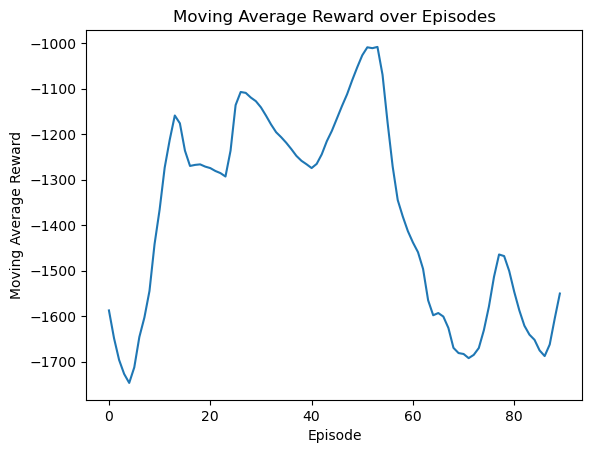

In [ ]:
# plot training 
def plot_moving_average_reward(episode_rewards, window_size=10):
    cumsum_rewards = np.cumsum(episode_rewards)
    moving_avg_rewards = (cumsum_rewards[window_size:] - cumsum_rewards[:-window_size]) / window_size

    plt.plot(moving_avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average Reward over Episodes')
    plt.show()

plot_moving_average_reward(reward_history)

In [ ]:
# need a virtual display for rendering in docker
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from IPython import display as ipythondisplay

# Test the trained agent

print("\nTesting the trained agent...")
state, _ = env.reset()
state = jnp.array(state, dtype=jnp.float32)

total_reward = 0
done = False
pre_screen = env.render()
step_in_episode = 0
actions = []
Tz = [state[1]]
P = [state[4]]
To = [state[2]]

while not done:
    action = agent.act(state, apply_epsilon=False)
    next_state, reward, done, _, _ = env.step(action)
    next_state = jnp.array(next_state, dtype=jnp.float32)
    screen = env.render()
    state = next_state
    total_reward += reward
    step_in_episode += 1

    # save for future use
    actions.append(action)
    Tz.append(next_state[1])
    P.append(next_state[4])
    To.append(next_state[2])
print(f"Total Reward: {total_reward}")

env.close()



Testing the trained agent...
env is reset!
Total Reward: -1264.5798827853505


7


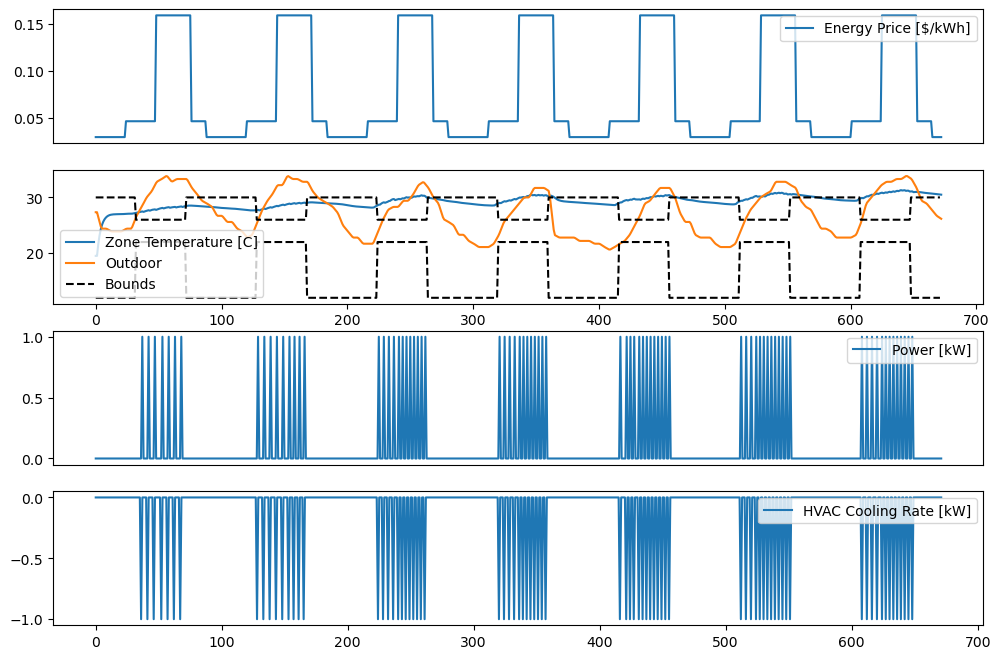

In [ ]:

n_days = step_in_episode*dt // (3600*24)
n_steps_per_hour = 3600 // dt
prices = env.energy_price
Tub = env.Tz_high
Tlb = env.Tz_low


# need make sure the length of Tub and Tlb is the same as Tz
prices = np.tile(prices.reshape(-1,1), (n_days, n_steps_per_hour))
Tub = np.tile(np.array(Tub).reshape(-1, 1), (n_days, n_steps_per_hour)) 
Tlb = np.tile(np.array(Tlb).reshape(-1, 1), (n_days, n_steps_per_hour)) 
# actions to actual cooling rate 
actions = [action/(n_actions-1)*(np.array(u_high) - np.array(u_low)) + np.array(u_low) for action in actions]

print(n_days)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(prices.flatten(), label='Energy Price [$/kWh]')
plt.xticks([])
plt.legend() 

plt.subplot(4,1,2)
plt.plot(Tz, label='Zone Temperature [C]')
plt.plot(To, label="Outdoor")
plt.plot(Tub.flatten(), 'k--', label='Bounds')
plt.plot(Tlb.flatten(), 'k--')
plt.legend()

plt.subplot(4,1,3)
plt.plot(P, label="Power [kW]")
plt.xticks([])
plt.legend()

plt.subplot(4,1,4)
plt.plot(actions, label="HVAC Cooling Rate [kW]")
plt.legend()
plt.savefig('dqn-rc.png')

In [ ]:
energy_cost = np.sum(prices.flatten()*np.array(P[1:])*dt/3600)
print(energy_cost)
energy = np.sum(np.array(P[1:])*dt/3600.)
print(energy)

2.3229825
19.75
